# Sentences

Let's use SpaCy to analyze sentence structure. First, import all the usual libraries, and get a few test texts from Dubliners by splitting on chapter headings:

In [127]:
import spacy
import pandas as pd
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

In [128]:
nlp = spacy.load('en_core_web_lg')

In [129]:
dublinersParts = open('dubliners.md').read().split('##')

In [130]:
dublinersParts = dublinersParts[1:]

In [131]:
dublinersParts = dublinersParts[:6]

In [132]:
len(dublinersParts)

6

In [133]:
dublinersDocs = [nlp(text) for text in dublinersParts]

In [134]:
dublinersLabels = ['The Sisters', 'An Encounter', 'Araby', 
                   'Eveline', 'After the Race', 'Two Gallants']

It's always a good idea to check the length of each text we're comparing. 

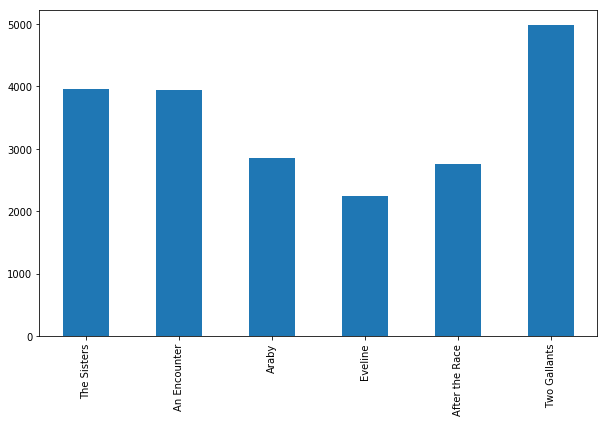

In [135]:
pd.Series([len(text) for text in dublinersDocs], 
          index=dublinersLabels).plot(kind='bar')

And check the number of sentences in each:

In [136]:
[len(list(doc.sents)) for doc in dublinersDocs]

[230, 204, 153, 135, 141, 316]

Make a list of all sentences in each. This list is going to be a list of lists: the outer list represents each story, and each inner list is a list of all the sentences in that story.

In [137]:
allSents = [list(doc.sents) for doc in dublinersDocs]

Make a list of the lengths of each sentence. This is also going to be a list of lists, where each inner list is a list of the lengths of each sentence. 

In [138]:
sentLengths = [[len(sent) for sent in doc] for doc in allSents]

Now we can average those lists: 

In [139]:
avgSentLen = [sum(lengths)/len(lengths) for lengths in sentLengths]

If we wanted to, we could also write that the long way, using a `for` loop. Either method is valid. Use whatever you're most comfortable with. I find list comprehensions more useful, but you might prefer the readability of a `for` loop. 

In [140]:
averages = []
for lengths in sentLengths: 
    total = sum(lengths)
    num = len(lengths)
    average = total/num
    averages.append(averages)

Let's peek at the average sentence lengths for each story:

In [141]:
avgSentLen

[17.213043478260868,
 19.29901960784314,
 18.640522875816995,
 16.57037037037037,
 19.49645390070922,
 15.762658227848101]

They're pretty similar. We could plot them if we wanted to: 

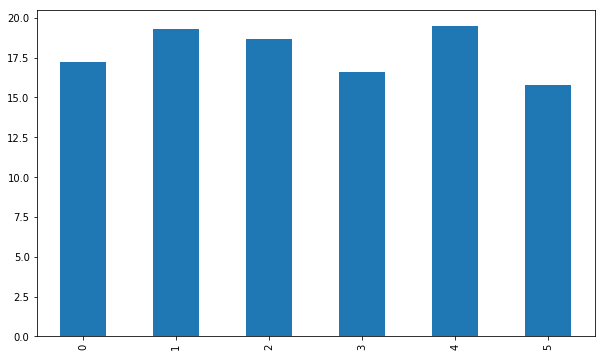

In [142]:
pd.Series(avgSentLen).plot(kind='bar')

## Dependency Parsing

We can use SpaCy to parse the syntactic relationships between words. For example, in the phrase "the quick brown fox," the words "quick" and "brown" are adjectives describing "fox," so we could say that they're *dependent* on "fox." First, I'll copy-and-paste some code here that I wrote earlier, to shoehorn SpaCy sentences into `ete3` objects, so that I can visualize them. You don't have to worry too much about how this code works (it's pretty complicated), and if you can't get it to work because you don't have the `ete3` library, don't worry about that, either, since there are different ways of visualizing syntax. 

In [143]:
## Code for visualizing sentences as trees. 
import ete3
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node

class sentenceTree(): 
    def __init__(self, sent): 
        """ Takes a SpaCy sentence as input. """ 
        self.sent = sent
        self.root = sent.root
        print(self.sent)
        self.sentDict = self.sentToDict(self.root)
        self.newick = self.newickify(self.sentDict) + ';'

    def isPunct(self, thing): 
        if type(thing) == str: 
            if thing.strip() in "!@#$%^&*()_+-=,./<>?;':[]\{}|`~": 
                return True
        return False

    def sentToDict(self, node): 
        children = [child for child in node.children 
                   if self.isPunct(child.string.strip()) == False # ignore punctuation
                   and child.tag_ != 'SP'] #ignore spaces and newlines
        root = node.string.strip()
        if len(children) == 0: 
            return node.string.strip()
        return {node.string.strip(): [self.sentToDict(child) 
                                      for child in children]}

    def newickify(self, node): 
        if type(node) == str:
            return node.strip()
        root = list(node)[0]
        return '(' + ','.join([self.newickify(child) 
            for child in node[root] ]) + ')' + root
    
    def render(self, textMode=False): 
        """ 
        textMode=False will show a graphical tree. 
        textmode=True will show an ASCII tree. 
        """
        t = Tree(self.newick, format=1)
        if textMode: 
            print(t.get_ascii(show_internal=True))
        else: 
            ts = TreeStyle()
            ts.show_leaf_name = False
            #TODO: make this not be a function
            def my_layout(node):
                F = TextFace(node.name, tight_text=False)
                add_face_to_node(F, node, column=0, position="branch-right")
            ts.layout_fn = my_layout        
            return t.render('%%inline', tree_style=ts)


First, make a SpaCy document out of an example sentence. 

In [144]:
foxDoc = nlp("The quick brown fox jumped over the lazy dogs.")

Since `doc.sents` is a generator (a thing which creates lists), we have to force it into a list using `list()` before we can index it: 

In [145]:
foxSent = list(foxDoc.sents)[0]

Now we can use my code to render it: 

The quick brown fox jumped over the lazy dogs.


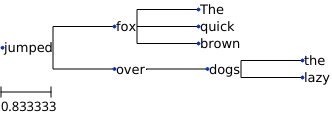

In [146]:
sentenceTree(foxSent).render()

## Navigating the Sentence Tree Using SpaCy

Let's explore the dependencies between various words and phrases using SpaCy. First, look at the sentence: 

In [147]:
foxSent

The quick brown fox jumped over the lazy dogs.

Every sentence has a root verb: 

In [148]:
foxSent.root

jumped

And every verb has a root form, or lemma: 

In [149]:
foxSent.root.lemma_

'jump'

Let's play around with the story "Eveline": 

In [150]:
evelineDoc = dublinersDocs[3]

Grab all the lemmas of all the root verbs, and make them into a Pandas Series object: 

In [151]:
s = pd.Series([sent.root.lemma_ for sent in evelineDoc.sents])

Now we can get their counts:

In [152]:
evelineVerbs = s.value_counts()
evelineVerbs.head()

be      25
have     8
use      5
give     4
come     4
dtype: int64

Do the same for "Araby":

In [153]:
arabyDoc = dublinersDocs[2]

In [154]:
arabyVerbs = pd.Series([sent.root.lemma_ for sent in arabyDoc.sents]).value_counts()
arabyVerbs.head()

be      19
say      6
ask      5
hear     4
go       4
dtype: int64

We can now compare these two Series objects using a Pandas DataFrame. Since our data frame is enormous, let's look at just a few verbs: 

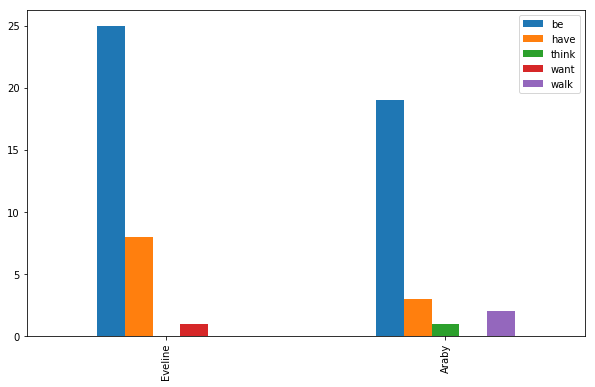

In [155]:
pd.DataFrame([evelineVerbs, arabyVerbs], 
             index=['Eveline', 'Araby'])[['be', 'have', 'think', 'want', 'walk']].fillna(0).plot(kind='bar')

In [156]:
foxSent

The quick brown fox jumped over the lazy dogs.

In [157]:
foxSent.root

jumped

In [158]:
foxRoot = foxSent.root

Every root verb has dependencies, or "children": 

In [159]:
list(foxRoot.children)

[fox, over, .]

In [160]:
fox = list(foxRoot.children)[0]

In [161]:
fox

fox

And some children also have children (you can think of this kind of like a family tree): 

In [162]:
list(fox.children)

[The, quick, brown]

In [164]:
frankSent = "Frank was very kind, manly, open-hearted."

In [165]:
frankDoc = nlp(frankSent)

In [166]:
frankSent = next(frankDoc.sents)

In [167]:
frankSent

Frank was very kind, manly, open-hearted.

Frank was very kind, manly, open-hearted.


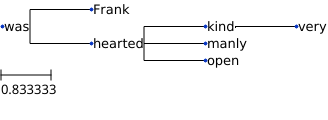

In [168]:
sentenceTree(frankSent).render()

If you want, you can write a function that navigates through this dependency graph, looking for, say, adjectives that are dependent on certain character names: 

In [170]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children:
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

In [171]:
adjectivesDescribingCharacters(arabyDoc, 'sister')

[('his', 1)]

## Visualizing Using DisplaCy

You can also visualize sentences a different way using SpaCy's built-in DisplaCy visualizer: 

In [172]:
spacy.displacy.render(frankDoc, jupyter=True, options={'distance': 90})

/usr/lib/python3.6/runpy.py:193: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)


...which you can also use to show, for instance, named entities that SpaCy recognizes: 

In [173]:
spacy.displacy.render(frankDoc, style='ent', jupyter=True, options={'distance': 90})